In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.0001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_00001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/793 [..............................] - ETA: 13:44 - loss: 0.0694 - STD: 3.4481e-04 - MAE: 0.2473

 11/793 [..............................] - ETA: 4s - loss: 0.0330 - STD: 2.9955e-04 - MAE: 0.1582   

 19/793 [..............................] - ETA: 4s - loss: 0.0232 - STD: 3.6963e-04 - MAE: 0.1244

 27/793 [>.............................] - ETA: 4s - loss: 0.0194 - STD: 4.0594e-04 - MAE: 0.1098

 36/793 [>.............................] - ETA: 4s - loss: 0.0171 - STD: 4.3390e-04 - MAE: 0.1010

 45/793 [>.............................] - ETA: 4s - loss: 0.0156 - STD: 4.6269e-04 - MAE: 0.0953

 54/793 [=>............................] - ETA: 4s - loss: 0.0145 - STD: 4.9501e-04 - MAE: 0.0920

 63/793 [=>............................] - ETA: 4s - loss: 0.0137 - STD: 5.3412e-04 - MAE: 0.0896

 72/793 [=>............................] - ETA: 4s - loss: 0.0132 - STD: 5.7829e-04 - MAE: 0.0880

 81/793 [==>...........................] - ETA: 4s - loss: 0.0128 - STD: 6.2734e-04 - MAE: 0.0867

 90/793 [==>...........................] - ETA: 4s - loss: 0.0124 - STD: 6.8104e-04 - MAE: 0.0856

 99/793 [==>...........................] - ETA: 4s - loss: 0.0121 - STD: 7.3942e-04 - MAE: 0.0846

108/793 [===>..........................] - ETA: 4s - loss: 0.0119 - STD: 8.0331e-04 - MAE: 0.0839

117/793 [===>..........................] - ETA: 4s - loss: 0.0117 - STD: 8.7181e-04 - MAE: 0.0832

126/793 [===>..........................] - ETA: 4s - loss: 0.0115 - STD: 9.4562e-04 - MAE: 0.0826

135/793 [====>.........................] - ETA: 3s - loss: 0.0113 - STD: 0.0010 - MAE: 0.0820    

144/793 [====>.........................] - ETA: 3s - loss: 0.0112 - STD: 0.0011 - MAE: 0.0816

153/793 [====>.........................] - ETA: 3s - loss: 0.0111 - STD: 0.0012 - MAE: 0.0812

162/793 [=====>........................] - ETA: 3s - loss: 0.0109 - STD: 0.0013 - MAE: 0.0808

171/793 [=====>........................] - ETA: 3s - loss: 0.0108 - STD: 0.0014 - MAE: 0.0805

180/793 [=====>........................] - ETA: 3s - loss: 0.0108 - STD: 0.0015 - MAE: 0.0803

189/793 [======>.......................] - ETA: 3s - loss: 0.0107 - STD: 0.0016 - MAE: 0.0799

198/793 [======>.......................] - ETA: 3s - loss: 0.0106 - STD: 0.0017 - MAE: 0.0796

207/793 [======>.......................] - ETA: 3s - loss: 0.0105 - STD: 0.0018 - MAE: 0.0794

216/793 [=======>......................] - ETA: 3s - loss: 0.0104 - STD: 0.0020 - MAE: 0.0791

225/793 [=======>......................] - ETA: 3s - loss: 0.0103 - STD: 0.0021 - MAE: 0.0789

231/793 [=======>......................] - ETA: 4s - loss: 0.0103 - STD: 0.0022 - MAE: 0.0787

242/793 [========>.....................] - ETA: 4s - loss: 0.0102 - STD: 0.0024 - MAE: 0.0785

251/793 [========>.....................] - ETA: 4s - loss: 0.0102 - STD: 0.0025 - MAE: 0.0783

260/793 [========>.....................] - ETA: 4s - loss: 0.0101 - STD: 0.0027 - MAE: 0.0781

269/793 [=========>....................] - ETA: 4s - loss: 0.0101 - STD: 0.0029 - MAE: 0.0779

278/793 [=========>....................] - ETA: 3s - loss: 0.0100 - STD: 0.0031 - MAE: 0.0777

287/793 [=========>....................] - ETA: 3s - loss: 0.0100 - STD: 0.0034 - MAE: 0.0776

296/793 [==========>...................] - ETA: 3s - loss: 0.0099 - STD: 0.0036 - MAE: 0.0775

305/793 [==========>...................] - ETA: 3s - loss: 0.0099 - STD: 0.0039 - MAE: 0.0773

314/793 [==========>...................] - ETA: 3s - loss: 0.0098 - STD: 0.0042 - MAE: 0.0771

323/793 [===========>..................] - ETA: 3s - loss: 0.0098 - STD: 0.0045 - MAE: 0.0770

332/793 [===========>..................] - ETA: 3s - loss: 0.0097 - STD: 0.0048 - MAE: 0.0768

341/793 [===========>..................] - ETA: 3s - loss: 0.0097 - STD: 0.0051 - MAE: 0.0767

350/793 [============>.................] - ETA: 3s - loss: 0.0096 - STD: 0.0055 - MAE: 0.0765

359/793 [============>.................] - ETA: 3s - loss: 0.0096 - STD: 0.0059 - MAE: 0.0763

368/793 [============>.................] - ETA: 3s - loss: 0.0095 - STD: 0.0063 - MAE: 0.0761

377/793 [=============>................] - ETA: 2s - loss: 0.0095 - STD: 0.0068 - MAE: 0.0760

386/793 [=============>................] - ETA: 2s - loss: 0.0094 - STD: 0.0072 - MAE: 0.0758

395/793 [=============>................] - ETA: 2s - loss: 0.0094 - STD: 0.0077 - MAE: 0.0757

404/793 [==============>...............] - ETA: 2s - loss: 0.0093 - STD: 0.0082 - MAE: 0.0755

413/793 [==============>...............] - ETA: 2s - loss: 0.0093 - STD: 0.0087 - MAE: 0.0754

422/793 [==============>...............] - ETA: 2s - loss: 0.0093 - STD: 0.0092 - MAE: 0.0752

431/793 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 0.0097 - MAE: 0.0750

440/793 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 0.0102 - MAE: 0.0749

449/793 [===============>..............] - ETA: 2s - loss: 0.0091 - STD: 0.0108 - MAE: 0.0748

458/793 [================>.............] - ETA: 2s - loss: 0.0091 - STD: 0.0113 - MAE: 0.0746

467/793 [================>.............] - ETA: 2s - loss: 0.0091 - STD: 0.0118 - MAE: 0.0745

476/793 [=================>............] - ETA: 2s - loss: 0.0090 - STD: 0.0123 - MAE: 0.0743

485/793 [=================>............] - ETA: 2s - loss: 0.0090 - STD: 0.0128 - MAE: 0.0742

494/793 [=================>............] - ETA: 2s - loss: 0.0090 - STD: 0.0133 - MAE: 0.0741

503/793 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.0137 - MAE: 0.0739

512/793 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.0142 - MAE: 0.0738

520/793 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.0146 - MAE: 0.0737

529/793 [===================>..........] - ETA: 1s - loss: 0.0088 - STD: 0.0150 - MAE: 0.0736

538/793 [===================>..........] - ETA: 1s - loss: 0.0088 - STD: 0.0155 - MAE: 0.0734

547/793 [===================>..........] - ETA: 1s - loss: 0.0088 - STD: 0.0159 - MAE: 0.0733

555/793 [===================>..........] - ETA: 1s - loss: 0.0088 - STD: 0.0163 - MAE: 0.0732

564/793 [====================>.........] - ETA: 1s - loss: 0.0087 - STD: 0.0167 - MAE: 0.0731

573/793 [====================>.........] - ETA: 1s - loss: 0.0087 - STD: 0.0171 - MAE: 0.0729

582/793 [=====================>........] - ETA: 1s - loss: 0.0087 - STD: 0.0175 - MAE: 0.0728

591/793 [=====================>........] - ETA: 1s - loss: 0.0086 - STD: 0.0179 - MAE: 0.0727

600/793 [=====================>........] - ETA: 1s - loss: 0.0086 - STD: 0.0183 - MAE: 0.0725

609/793 [======================>.......] - ETA: 1s - loss: 0.0086 - STD: 0.0186 - MAE: 0.0724

618/793 [======================>.......] - ETA: 1s - loss: 0.0086 - STD: 0.0190 - MAE: 0.0723

627/793 [======================>.......] - ETA: 1s - loss: 0.0085 - STD: 0.0193 - MAE: 0.0722

636/793 [=======================>......] - ETA: 1s - loss: 0.0085 - STD: 0.0197 - MAE: 0.0721

645/793 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.0200 - MAE: 0.0720

654/793 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.0204 - MAE: 0.0719

663/793 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.0207 - MAE: 0.0718

672/793 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.0210 - MAE: 0.0716

680/793 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.0213 - MAE: 0.0715

688/793 [=========================>....] - ETA: 0s - loss: 0.0084 - STD: 0.0216 - MAE: 0.0714

697/793 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.0219 - MAE: 0.0713

706/793 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.0222 - MAE: 0.0712

715/793 [==========================>...] - ETA: 0s - loss: 0.0083 - STD: 0.0225 - MAE: 0.0711

724/793 [==========================>...] - ETA: 0s - loss: 0.0083 - STD: 0.0228 - MAE: 0.0710

733/793 [==========================>...] - ETA: 0s - loss: 0.0082 - STD: 0.0231 - MAE: 0.0708

742/793 [===========================>..] - ETA: 0s - loss: 0.0082 - STD: 0.0234 - MAE: 0.0707

751/793 [===========================>..] - ETA: 0s - loss: 0.0082 - STD: 0.0237 - MAE: 0.0706

760/793 [===========================>..] - ETA: 0s - loss: 0.0082 - STD: 0.0240 - MAE: 0.0705

769/793 [============================>.] - ETA: 0s - loss: 0.0081 - STD: 0.0243 - MAE: 0.0704

778/793 [============================>.] - ETA: 0s - loss: 0.0081 - STD: 0.0246 - MAE: 0.0703

787/793 [============================>.] - ETA: 0s - loss: 0.0081 - STD: 0.0249 - MAE: 0.0701

793/793 [==============================] - 7s 7ms/step - loss: 0.0081 - STD: 0.0251 - MAE: 0.0700 - val_loss: 0.0053 - val_STD: 0.0299 - val_MAE: 0.0555


Epoch 2/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0061 - STD: 0.0522 - MAE: 0.0602

  8/793 [..............................] - ETA: 5s - loss: 0.0060 - STD: 0.0513 - MAE: 0.0595 

 17/793 [..............................] - ETA: 5s - loss: 0.0059 - STD: 0.0515 - MAE: 0.0590

 26/793 [..............................] - ETA: 4s - loss: 0.0058 - STD: 0.0512 - MAE: 0.0590

 35/793 [>.............................] - ETA: 4s - loss: 0.0058 - STD: 0.0515 - MAE: 0.0586

 44/793 [>.............................] - ETA: 4s - loss: 0.0058 - STD: 0.0518 - MAE: 0.0585

 53/793 [=>............................] - ETA: 4s - loss: 0.0058 - STD: 0.0521 - MAE: 0.0584

 62/793 [=>............................] - ETA: 4s - loss: 0.0057 - STD: 0.0524 - MAE: 0.0584

 71/793 [=>............................] - ETA: 4s - loss: 0.0057 - STD: 0.0526 - MAE: 0.0583

 80/793 [==>...........................] - ETA: 4s - loss: 0.0057 - STD: 0.0529 - MAE: 0.0581

 89/793 [==>...........................] - ETA: 4s - loss: 0.0057 - STD: 0.0531 - MAE: 0.0579

 98/793 [==>...........................] - ETA: 4s - loss: 0.0056 - STD: 0.0535 - MAE: 0.0578

107/793 [===>..........................] - ETA: 4s - loss: 0.0056 - STD: 0.0538 - MAE: 0.0577

116/793 [===>..........................] - ETA: 4s - loss: 0.0056 - STD: 0.0541 - MAE: 0.0577

125/793 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0543 - MAE: 0.0576

134/793 [====>.........................] - ETA: 3s - loss: 0.0056 - STD: 0.0545 - MAE: 0.0575

143/793 [====>.........................] - ETA: 3s - loss: 0.0056 - STD: 0.0547 - MAE: 0.0574

152/793 [====>.........................] - ETA: 3s - loss: 0.0056 - STD: 0.0549 - MAE: 0.0573

161/793 [=====>........................] - ETA: 3s - loss: 0.0056 - STD: 0.0550 - MAE: 0.0573

170/793 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0552 - MAE: 0.0572

179/793 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0554 - MAE: 0.0571

188/793 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0556 - MAE: 0.0570

197/793 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0558 - MAE: 0.0570

206/793 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0560 - MAE: 0.0569

215/793 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0562 - MAE: 0.0568

224/793 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0564 - MAE: 0.0567

233/793 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0566 - MAE: 0.0567

242/793 [========>.....................] - ETA: 3s - loss: 0.0055 - STD: 0.0567 - MAE: 0.0566

251/793 [========>.....................] - ETA: 3s - loss: 0.0055 - STD: 0.0569 - MAE: 0.0565

260/793 [========>.....................] - ETA: 3s - loss: 0.0054 - STD: 0.0570 - MAE: 0.0565

269/793 [=========>....................] - ETA: 3s - loss: 0.0054 - STD: 0.0571 - MAE: 0.0564

278/793 [=========>....................] - ETA: 3s - loss: 0.0054 - STD: 0.0573 - MAE: 0.0563

287/793 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0574 - MAE: 0.0563

296/793 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0575 - MAE: 0.0562

305/793 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0576 - MAE: 0.0561

313/793 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0576 - MAE: 0.0561

322/793 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0577 - MAE: 0.0560

331/793 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0578 - MAE: 0.0560

340/793 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0579 - MAE: 0.0559

349/793 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0580 - MAE: 0.0558

358/793 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0581 - MAE: 0.0558

367/793 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0582 - MAE: 0.0557

376/793 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0583 - MAE: 0.0557

385/793 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0584 - MAE: 0.0556

394/793 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0586 - MAE: 0.0555

403/793 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0586 - MAE: 0.0555

412/793 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0587 - MAE: 0.0554

421/793 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0588 - MAE: 0.0554

430/793 [===============>..............] - ETA: 2s - loss: 0.0053 - STD: 0.0589 - MAE: 0.0553

439/793 [===============>..............] - ETA: 2s - loss: 0.0053 - STD: 0.0591 - MAE: 0.0552

448/793 [===============>..............] - ETA: 2s - loss: 0.0052 - STD: 0.0591 - MAE: 0.0552

457/793 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0592 - MAE: 0.0551

466/793 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0593 - MAE: 0.0551

475/793 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0594 - MAE: 0.0550

484/793 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0594 - MAE: 0.0549

492/793 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0595 - MAE: 0.0549

501/793 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0596 - MAE: 0.0548

510/793 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0597 - MAE: 0.0548

519/793 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0598 - MAE: 0.0547

528/793 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0599 - MAE: 0.0547

537/793 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0600 - MAE: 0.0546

546/793 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0601 - MAE: 0.0546

555/793 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0602 - MAE: 0.0545

564/793 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0603 - MAE: 0.0544

573/793 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0603 - MAE: 0.0544

582/793 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0604 - MAE: 0.0543

591/793 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0543

600/793 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0542

609/793 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0607 - MAE: 0.0542

617/793 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0608 - MAE: 0.0541

626/793 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0608 - MAE: 0.0541

635/793 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0609 - MAE: 0.0540

644/793 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0610 - MAE: 0.0539

653/793 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0611 - MAE: 0.0539

662/793 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0612 - MAE: 0.0539

670/793 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0612 - MAE: 0.0538

679/793 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0613 - MAE: 0.0538

688/793 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0614 - MAE: 0.0537

697/793 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0614 - MAE: 0.0537

706/793 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0615 - MAE: 0.0536

715/793 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0616 - MAE: 0.0536

724/793 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0616 - MAE: 0.0536

733/793 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0535

742/793 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0535

751/793 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0534

760/793 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0619 - MAE: 0.0534

769/793 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0533

778/793 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0533

787/793 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0621 - MAE: 0.0533

793/793 [==============================] - 5s 6ms/step - loss: 0.0049 - STD: 0.0621 - MAE: 0.0532 - val_loss: 0.0039 - val_STD: 0.0518 - val_MAE: 0.0472


Epoch 3/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0491

 10/793 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0669 - MAE: 0.0498 

 19/793 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0491

 28/793 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0491

 37/793 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0491

 46/793 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0492

 54/793 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0492

 63/793 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0493

 72/793 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0492

 81/793 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0492

 89/793 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0492

 98/793 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0492

107/793 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0492

116/793 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0493

125/793 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0493

134/793 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0493

142/793 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0493

151/793 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0493

160/793 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0492

169/793 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0492

178/793 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0491

187/793 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0491

196/793 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0491

205/793 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0491

214/793 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0490

223/793 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0490

232/793 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0490

240/793 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0490

249/793 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0489

258/793 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0489

267/793 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0489

276/793 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0489

285/793 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0489

294/793 [==========>...................] - ETA: 3s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0489

303/793 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0489

312/793 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0489

321/793 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0489

330/793 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0489

339/793 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0488

348/793 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0488

357/793 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0488

366/793 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0488

375/793 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0488

384/793 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0488

393/793 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0488

402/793 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0488

411/793 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0488

420/793 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0488

429/793 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0488

438/793 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0488

447/793 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0487

456/793 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0487

465/793 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0487

474/793 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0487

483/793 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0487

492/793 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0487

501/793 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0487

510/793 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0487

519/793 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0486

527/793 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0486

535/793 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0486

544/793 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0486

553/793 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0486

562/793 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0486

571/793 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0486

579/793 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0486

588/793 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0486

597/793 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0486

606/793 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0486

615/793 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0485

624/793 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0485

633/793 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0485

642/793 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0485

651/793 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0485

660/793 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0485

669/793 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0484

678/793 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0484

687/793 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0484

696/793 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0484

705/793 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0484

713/793 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0484

721/793 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0484

730/793 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0484

739/793 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0484

748/793 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0484

757/793 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0483

766/793 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0483

775/793 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0483

784/793 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0483

793/793 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0483

793/793 [==============================] - 5s 6ms/step - loss: 0.0042 - STD: 0.0701 - MAE: 0.0483 - val_loss: 0.0036 - val_STD: 0.0568 - val_MAE: 0.0455


Epoch 4/10000


  1/793 [..............................] - ETA: 21s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0495

  8/793 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0723 - MAE: 0.0482 

 17/793 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

 26/793 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

 35/793 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0476

 44/793 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

 53/793 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

 62/793 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

 71/793 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

 80/793 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

 89/793 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

 98/793 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0475

107/793 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0475

116/793 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

125/793 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0474

134/793 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0473

143/793 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0473

152/793 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

161/793 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

170/793 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

179/793 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

188/793 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

197/793 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

206/793 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

215/793 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

224/793 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

233/793 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

242/793 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

251/793 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

260/793 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

269/793 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

278/793 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

287/793 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

295/793 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

304/793 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

313/793 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

322/793 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

331/793 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

340/793 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

349/793 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

358/793 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

367/793 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0471

376/793 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0471

385/793 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0471

394/793 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

403/793 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

412/793 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

421/793 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

429/793 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

438/793 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

447/793 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

456/793 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

465/793 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

473/793 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

482/793 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

491/793 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

500/793 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

509/793 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

518/793 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

527/793 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

536/793 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

545/793 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

554/793 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

563/793 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0470

572/793 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0470

581/793 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0470

590/793 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0470

599/793 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0470

608/793 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

617/793 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

626/793 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

635/793 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

644/793 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

653/793 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

662/793 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

671/793 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

680/793 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

689/793 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

697/793 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

706/793 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

715/793 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

724/793 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

733/793 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

742/793 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

751/793 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0469

760/793 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

769/793 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

778/793 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

787/793 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

793/793 [==============================] - 5s 6ms/step - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469 - val_loss: 0.0034 - val_STD: 0.0559 - val_MAE: 0.0434


Epoch 5/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0460

  7/793 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462 

 15/793 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

 24/793 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

 33/793 [>.............................] - ETA: 5s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

 42/793 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0464

 51/793 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

 59/793 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

 67/793 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0467

 76/793 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

 84/793 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

 93/793 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

102/793 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

111/793 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

120/793 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

129/793 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

138/793 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

147/793 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

156/793 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

165/793 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

174/793 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

183/793 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

192/793 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

201/793 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

210/793 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

219/793 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

228/793 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

237/793 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

245/793 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

254/793 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

263/793 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

272/793 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

281/793 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

290/793 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

299/793 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

307/793 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

316/793 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

325/793 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

334/793 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

343/793 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

352/793 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

361/793 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

370/793 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

379/793 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

388/793 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0466

397/793 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0465

406/793 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0465

415/793 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0465

424/793 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0465

433/793 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0465

442/793 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0465

451/793 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0465

460/793 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0465

469/793 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0464

478/793 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0465

487/793 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0465

496/793 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0465

504/793 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0465

513/793 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0465

522/793 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0464

531/793 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0464

540/793 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0464

548/793 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0464

556/793 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

565/793 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0464

574/793 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

583/793 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

592/793 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

601/793 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

610/793 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

619/793 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

628/793 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

637/793 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

646/793 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

655/793 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

664/793 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

673/793 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

682/793 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

691/793 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

700/793 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

709/793 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

718/793 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

727/793 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

736/793 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0464

745/793 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0464

754/793 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

762/793 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

770/793 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

779/793 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

788/793 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

793/793 [==============================] - 5s 7ms/step - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463 - val_loss: 0.0033 - val_STD: 0.0593 - val_MAE: 0.0433


Epoch 6/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0464

  8/793 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0456 

 17/793 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

 26/793 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

 35/793 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

 44/793 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

 53/793 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

 62/793 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

 71/793 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

 79/793 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

 88/793 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

 97/793 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

106/793 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

115/793 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

124/793 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

133/793 [====>.........................] - ETA: 4s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0458

142/793 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0458

151/793 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0458

160/793 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0458

169/793 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

178/793 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0458

187/793 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0458

196/793 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

205/793 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

214/793 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0459

223/793 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0459

232/793 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0459

241/793 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0459

250/793 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0458

259/793 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0458

268/793 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0458

277/793 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0458

286/793 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0458

295/793 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0458

304/793 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0458

313/793 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0458

322/793 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0458

331/793 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0459

340/793 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0459

349/793 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

358/793 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

367/793 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

376/793 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

385/793 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

393/793 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

402/793 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

411/793 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

420/793 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

429/793 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

438/793 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

447/793 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

456/793 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

465/793 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

474/793 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

483/793 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

492/793 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

501/793 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

510/793 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

519/793 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

528/793 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

537/793 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0459

544/793 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

553/793 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

562/793 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

571/793 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

580/793 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

589/793 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

598/793 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

607/793 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

616/793 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

625/793 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

634/793 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

643/793 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

652/793 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

661/793 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

670/793 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

679/793 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

688/793 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

697/793 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

706/793 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

715/793 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

724/793 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

733/793 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

742/793 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

751/793 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

760/793 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

769/793 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

778/793 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

787/793 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

793/793 [==============================] - 5s 6ms/step - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459 - val_loss: 0.0033 - val_STD: 0.0565 - val_MAE: 0.0423


Epoch 7/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0466

  9/793 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0455 

 18/793 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0458

 27/793 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0456

 36/793 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

 44/793 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

 53/793 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

 62/793 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

 71/793 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

 80/793 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

 89/793 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

 98/793 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0454

107/793 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0455

116/793 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

125/793 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455

134/793 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455

143/793 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455

151/793 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0456

160/793 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

169/793 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

178/793 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

187/793 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

196/793 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0456

205/793 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

214/793 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0456

223/793 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

232/793 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

241/793 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

250/793 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

259/793 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

268/793 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

277/793 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

286/793 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

295/793 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

304/793 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

313/793 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

322/793 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

331/793 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

340/793 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

349/793 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

358/793 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

367/793 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

376/793 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

385/793 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

394/793 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

403/793 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

412/793 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

421/793 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

430/793 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

438/793 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

446/793 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

455/793 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

464/793 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

473/793 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

482/793 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

491/793 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

500/793 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

508/793 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

517/793 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

526/793 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

535/793 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

544/793 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

553/793 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

562/793 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

571/793 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

580/793 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

589/793 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

598/793 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

607/793 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

616/793 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

625/793 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

634/793 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

643/793 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

652/793 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

661/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

670/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

679/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

688/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

697/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

706/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

715/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

721/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

729/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

738/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

747/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

756/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

765/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

774/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

783/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

792/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

793/793 [==============================] - 5s 6ms/step - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453 - val_loss: 0.0032 - val_STD: 0.0589 - val_MAE: 0.0419


Epoch 8/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0447

  9/793 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0453 

 17/793 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

 25/793 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

 34/793 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

 43/793 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

 52/793 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

 60/793 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

 68/793 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

 76/793 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

 84/793 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

 92/793 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

100/793 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

108/793 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

116/793 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0452

125/793 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

133/793 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

141/793 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0452

149/793 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0452

157/793 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0452

166/793 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0452

174/793 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0452

182/793 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0452

190/793 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0452

198/793 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0452

206/793 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0452

215/793 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0452

223/793 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0452

231/793 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0452

239/793 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0451

247/793 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0451

256/793 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0452

265/793 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0451

274/793 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0452

283/793 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0451

291/793 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0451

300/793 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0451

309/793 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0451

317/793 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0451

326/793 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0451

335/793 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0451

344/793 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

353/793 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

362/793 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

371/793 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

380/793 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

389/793 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

398/793 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

407/793 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

416/793 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

425/793 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

434/793 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

443/793 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

451/793 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

460/793 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

469/793 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0451

478/793 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0451

487/793 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0451

496/793 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0451

505/793 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0451

514/793 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0451

523/793 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0451

532/793 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0451

540/793 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0451

548/793 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0451

556/793 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0451

564/793 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0451

572/793 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0451

581/793 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0451

590/793 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

599/793 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

608/793 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

617/793 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

626/793 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

635/793 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

644/793 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

653/793 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

662/793 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

671/793 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

680/793 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

689/793 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

698/793 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

707/793 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

716/793 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

725/793 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

734/793 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

743/793 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

752/793 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

761/793 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

770/793 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

779/793 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

788/793 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

793/793 [==============================] - 5s 7ms/step - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450 - val_loss: 0.0032 - val_STD: 0.0610 - val_MAE: 0.0427


Epoch 9/10000


  1/793 [..............................] - ETA: 25s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0481

  7/793 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0451 

 16/793 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0449

 25/793 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

 34/793 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447

 43/793 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

 52/793 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447

 61/793 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0446

 69/793 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0447

 78/793 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0447

 85/793 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

 93/793 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

102/793 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

111/793 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

120/793 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

129/793 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

138/793 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

146/793 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

154/793 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

163/793 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

172/793 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

181/793 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

190/793 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

199/793 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

208/793 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

216/793 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

225/793 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

234/793 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

243/793 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

252/793 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

261/793 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

270/793 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

279/793 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

288/793 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

297/793 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

306/793 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

315/793 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

324/793 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

333/793 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

342/793 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

351/793 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

359/793 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

368/793 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

377/793 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

386/793 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

395/793 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

404/793 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

413/793 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

422/793 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

431/793 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

440/793 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

449/793 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

458/793 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

467/793 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

476/793 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

485/793 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

494/793 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

503/793 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

512/793 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

521/793 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

530/793 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

539/793 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

548/793 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

557/793 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

566/793 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

575/793 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

584/793 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

593/793 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

602/793 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

611/793 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

619/793 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

628/793 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

637/793 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

646/793 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

655/793 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

664/793 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

673/793 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

682/793 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

691/793 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

700/793 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

709/793 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

718/793 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

727/793 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

736/793 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

745/793 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

754/793 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

763/793 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

772/793 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

781/793 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

790/793 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

793/793 [==============================] - 5s 6ms/step - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446 - val_loss: 0.0031 - val_STD: 0.0610 - val_MAE: 0.0416


Epoch 10/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0432

  8/793 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0445 

 16/793 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

 25/793 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

 34/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

 42/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0444

 51/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

 60/793 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0446

 69/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0445

 78/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0445

 87/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

 96/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

105/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

114/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

123/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

132/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

141/793 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

150/793 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

158/793 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

167/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

176/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

185/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

194/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

203/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

212/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

221/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0444

229/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0444

238/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

247/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

256/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

265/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

274/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

283/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

292/793 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0444

301/793 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0444

310/793 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0444

319/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0444

328/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

337/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

346/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

354/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

363/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

372/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

381/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

390/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

399/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

408/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

417/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

426/793 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

435/793 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

444/793 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

453/793 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

462/793 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

471/793 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

480/793 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

489/793 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

498/793 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

507/793 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

516/793 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

525/793 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

532/793 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

539/793 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

548/793 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

557/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

566/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

575/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

584/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

593/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

602/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

611/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

620/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

629/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

638/793 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

647/793 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

656/793 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

665/793 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

674/793 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

683/793 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

692/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

701/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

710/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

719/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

728/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

737/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0443

746/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0443

755/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0443

764/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0443

773/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0443

782/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0443

791/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0443

793/793 [==============================] - 5s 6ms/step - loss: 0.0035 - STD: 0.0751 - MAE: 0.0443 - val_loss: 0.0031 - val_STD: 0.0613 - val_MAE: 0.0412


Epoch 11/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0436

  8/793 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0437 

 17/793 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0440

 26/793 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0442

 35/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

 44/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0442

 53/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0441

 62/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0441

 71/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0441

 80/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0442

 89/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0441

 98/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0441

107/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0441

116/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0441

125/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0441

134/793 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0440

143/793 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0441

152/793 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0441

161/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0441

170/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0441

179/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0441

188/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0441

197/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0441

206/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0441

215/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0441

224/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0440

233/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0440

242/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0440

251/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0441

260/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

269/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

278/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

287/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

296/793 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

305/793 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

314/793 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

323/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

332/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

341/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

350/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

359/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

368/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

376/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

384/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

393/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

402/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

411/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

420/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

429/793 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

438/793 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

447/793 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

456/793 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

465/793 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

474/793 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

483/793 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

492/793 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

501/793 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

510/793 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

519/793 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

527/793 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

535/793 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

544/793 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

553/793 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

562/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

571/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

580/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

589/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

598/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

607/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

616/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

625/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

634/793 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

643/793 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

652/793 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

661/793 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

670/793 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

679/793 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

688/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

697/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

706/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

715/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

724/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

733/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

742/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

751/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

760/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

769/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

778/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

787/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

793/793 [==============================] - 5s 6ms/step - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440 - val_loss: 0.0031 - val_STD: 0.0592 - val_MAE: 0.0408


Epoch 12/10000


  1/793 [..............................] - ETA: 21s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0426

  9/793 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434 

 18/793 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

 27/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0439

 36/793 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0438

 45/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

 54/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

 63/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0438

 72/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0439

 81/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0438

 90/793 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0438

 99/793 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0438

108/793 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0437

117/793 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0437

126/793 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0437

135/793 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0438

144/793 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0438

153/793 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0438

162/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0438

171/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

180/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

189/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

198/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

207/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

216/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

225/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

234/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

243/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

252/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

261/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

270/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

279/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

288/793 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

297/793 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

306/793 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

315/793 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

324/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

333/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

342/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

351/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

360/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

369/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

378/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

387/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

396/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

405/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

414/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

423/793 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

432/793 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

441/793 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

450/793 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

459/793 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

468/793 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

477/793 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

486/793 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

495/793 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

504/793 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

513/793 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

522/793 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

531/793 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

540/793 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

549/793 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

558/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

567/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

576/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

585/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

594/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

603/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

612/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

621/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

630/793 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

639/793 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

648/793 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

657/793 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

666/793 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0439

675/793 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

684/793 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

693/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

702/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

711/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

720/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

729/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

738/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

747/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

756/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

765/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

774/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

783/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

792/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

793/793 [==============================] - 5s 6ms/step - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438 - val_loss: 0.0031 - val_STD: 0.0591 - val_MAE: 0.0405


Epoch 13/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0034 - STD: 0.0740 - MAE: 0.0437

  9/793 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0434 

 18/793 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0768 - MAE: 0.0436

 27/793 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0436

 36/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0435

 45/793 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0435

 54/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0436

 63/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0437

 72/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0439

 81/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0440

 90/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0439

 99/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0438

108/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0438

117/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

126/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

135/793 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0437

144/793 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0437

153/793 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0437

162/793 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0437

171/793 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0437

180/793 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0437

189/793 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0437

198/793 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0437

207/793 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0437

216/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

225/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

234/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

243/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

252/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

261/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

270/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

279/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

288/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

297/793 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

306/793 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

315/793 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

324/793 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

333/793 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

342/793 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

351/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

360/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

369/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

378/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

387/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

396/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

405/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

414/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

423/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

432/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

441/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

450/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

459/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

468/793 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

477/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

486/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

495/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

504/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

513/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

522/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

531/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

540/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

549/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

558/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

567/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

576/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

585/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

594/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

603/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

612/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

621/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

630/793 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

639/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

648/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

657/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

666/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

675/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

684/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

693/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

702/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

711/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

720/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

729/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

737/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

745/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

753/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

762/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

771/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

780/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

789/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

793/793 [==============================] - 5s 6ms/step - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435 - val_loss: 0.0032 - val_STD: 0.0645 - val_MAE: 0.0429


Epoch 14/10000


  1/793 [..............................] - ETA: 25s - loss: 0.0038 - STD: 0.0806 - MAE: 0.0460

  9/793 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0443 

 18/793 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0441

 27/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0440

 36/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0442

 45/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0443

 54/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0443

 63/793 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0444

 72/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0443

 81/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0442

 90/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0442

 99/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0441

108/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0440

117/793 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0440

126/793 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0439

134/793 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0438

143/793 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0438

152/793 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0438

160/793 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0437

169/793 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0437

178/793 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0437

187/793 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

196/793 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

205/793 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

213/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

222/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

230/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

239/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

248/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

257/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

266/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

274/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

283/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

292/793 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

301/793 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

310/793 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

319/793 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

328/793 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

337/793 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

346/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

355/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

364/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

373/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

382/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

391/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

400/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

409/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

418/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

427/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

436/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

445/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

454/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

463/793 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

472/793 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

481/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

490/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

499/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

508/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

517/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

526/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

535/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

544/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

553/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

562/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

571/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

580/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

589/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

598/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

607/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

616/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

625/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

634/793 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

643/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

652/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

661/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

670/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

679/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

688/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

697/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

706/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

715/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

724/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

733/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

742/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

751/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

760/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

769/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

778/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

787/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

793/793 [==============================] - 5s 6ms/step - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433 - val_loss: 0.0030 - val_STD: 0.0617 - val_MAE: 0.0405


Epoch 15/10000


  1/793 [..............................] - ETA: 22s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0452

  7/793 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0438 

 15/793 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0438

 24/793 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0435

 33/793 [>.............................] - ETA: 5s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0431

 42/793 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0430

 51/793 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0430

 59/793 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

 68/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

 77/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

 86/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

 95/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

104/793 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

112/793 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

120/793 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

129/793 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

138/793 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

147/793 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

156/793 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

165/793 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

174/793 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

183/793 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

192/793 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

201/793 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

210/793 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

219/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

228/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

237/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

246/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

255/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

264/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

273/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

282/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

291/793 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

300/793 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

309/793 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

318/793 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

326/793 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

335/793 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

344/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

353/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

361/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

370/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

379/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

388/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

397/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

406/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

415/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

424/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

433/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

442/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

451/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

460/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

469/793 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

478/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

487/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

496/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

505/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

514/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

522/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

531/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

540/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

549/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

558/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

567/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

576/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

585/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

594/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

603/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

612/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

621/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

630/793 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

639/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

648/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

657/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

666/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

675/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

684/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

693/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

702/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

711/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

720/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

729/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

738/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

747/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

756/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

765/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

774/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

783/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

792/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

793/793 [==============================] - 5s 6ms/step - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431 - val_loss: 0.0030 - val_STD: 0.0613 - val_MAE: 0.0400


Epoch 16/10000


  1/793 [..............................] - ETA: 22s - loss: 0.0031 - STD: 0.0765 - MAE: 0.0419

  7/793 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429 

 15/793 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0431

 24/793 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

 33/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

 42/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

 51/793 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

 60/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0430

 69/793 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

 78/793 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

 87/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

 96/793 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

105/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

114/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

123/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

132/793 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

141/793 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

150/793 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

159/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

168/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

177/793 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

186/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

195/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

204/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

213/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

222/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

231/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

240/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

249/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

258/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

267/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

276/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

285/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

294/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

302/793 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

311/793 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

320/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

329/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

338/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

347/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

356/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

365/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

374/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

383/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

392/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

401/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

410/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

419/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

428/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

437/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

446/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

455/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

464/793 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

473/793 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

482/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

491/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

500/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

509/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

518/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

527/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

536/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

545/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

554/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

563/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

572/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

581/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

590/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

599/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

608/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

617/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

626/793 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

635/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

644/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

653/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

662/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

671/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

680/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

689/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

698/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

707/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

716/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

725/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

734/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

743/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

752/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

761/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

770/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

779/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

788/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

793/793 [==============================] - 5s 6ms/step - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429 - val_loss: 0.0030 - val_STD: 0.0618 - val_MAE: 0.0400


Epoch 17/10000


  1/793 [..............................] - ETA: 21s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0417

 10/793 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421 

 19/793 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

 28/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0428

 37/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

 46/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

 55/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

 64/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

 73/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

 82/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

 91/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

100/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

109/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0429

118/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0429

127/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0429

136/793 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0430

145/793 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

154/793 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

163/793 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

172/793 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

181/793 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

191/793 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0431

200/793 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0431

209/793 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0431

218/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

227/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0431

237/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0431

246/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

255/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0431

264/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

273/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

282/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

291/793 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

300/793 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

309/793 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

318/793 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

327/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0430

336/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0430

345/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0430

354/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0430

363/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

371/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

380/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

389/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

398/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

407/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

416/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

425/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

434/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

443/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

452/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

461/793 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

470/793 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

479/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

488/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

497/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

506/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

515/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

524/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

533/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

542/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

551/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

560/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

569/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

578/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

587/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

596/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

605/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

614/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

623/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

632/793 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

641/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

650/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

659/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

668/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

677/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

686/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

695/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

704/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

713/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

722/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

731/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

740/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

749/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

758/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

767/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

776/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

785/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

793/793 [==============================] - 5s 6ms/step - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428 - val_loss: 0.0029 - val_STD: 0.0626 - val_MAE: 0.0400


Epoch 18/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0029 - STD: 0.0775 - MAE: 0.0407

 10/793 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0426 

 19/793 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

 28/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

 37/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0429

 46/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

 55/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

 64/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

 73/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

 82/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

 91/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

100/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

109/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

118/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

127/793 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

136/793 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

145/793 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

154/793 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

163/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

172/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

181/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

190/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

199/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

208/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

217/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

226/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

235/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

244/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

253/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

262/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

271/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

280/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

289/793 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

298/793 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

307/793 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

316/793 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

325/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

334/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

343/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

352/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

361/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

370/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

379/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

388/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

397/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

406/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

415/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

423/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

431/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

440/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

449/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

458/793 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

467/793 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

476/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

485/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

494/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

503/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

512/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

521/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

530/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

538/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

546/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

555/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

564/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

573/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

582/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

591/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

600/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

609/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

618/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

627/793 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

636/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

645/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

654/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

663/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

672/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

681/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

690/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

699/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

708/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

717/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

725/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

733/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

742/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

751/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

760/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

769/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

778/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

787/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

793/793 [==============================] - 5s 6ms/step - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426 - val_loss: 0.0030 - val_STD: 0.0628 - val_MAE: 0.0405


Epoch 19/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0446

  9/793 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0434 

 18/793 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

 27/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0423

 36/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0424

 45/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0424

 54/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

 62/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

 71/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0423

 80/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0423

 89/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

 98/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

107/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

116/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

125/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

134/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

143/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

152/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

161/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

169/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

178/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

187/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

196/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

205/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

214/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

223/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

232/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

241/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

250/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

259/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

268/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

277/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

285/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

294/793 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

303/793 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

312/793 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

321/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

330/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

339/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

348/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

357/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

366/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

375/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

384/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

393/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

402/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

411/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

420/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

429/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

438/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

447/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

456/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

465/793 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

474/793 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

483/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

492/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

501/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

510/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

519/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

528/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

537/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

546/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

555/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

564/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

573/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

582/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

591/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

600/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

609/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

618/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

627/793 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

636/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

645/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

654/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

663/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

672/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

681/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

690/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

699/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

708/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

717/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

726/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

735/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

744/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

753/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

762/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

771/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

780/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

789/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

793/793 [==============================] - 5s 6ms/step - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424 - val_loss: 0.0029 - val_STD: 0.0613 - val_MAE: 0.0395


Epoch 20/10000


  1/793 [..............................] - ETA: 23s - loss: 0.0031 - STD: 0.0762 - MAE: 0.0414

  9/793 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418 

 18/793 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0424

 27/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

 36/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

 45/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

 54/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

 63/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

 72/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

 81/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

 90/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

 99/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

108/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

117/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

126/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

135/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

144/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

153/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

162/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

171/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

180/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

189/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

198/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

207/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

216/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

225/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

234/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

243/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

252/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

261/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

270/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

279/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

288/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

297/793 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

306/793 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

315/793 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

324/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

333/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

342/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

351/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

360/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

369/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

378/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

387/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

396/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

405/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

414/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

423/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

431/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

440/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

449/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

458/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

466/793 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

475/793 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

484/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

493/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

502/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

511/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

520/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

529/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

538/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

547/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

556/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

565/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

574/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

583/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

592/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

601/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

610/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

619/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

628/793 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

637/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

646/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

655/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

664/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

673/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

682/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

691/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

700/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

709/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

718/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

727/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

736/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

745/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

754/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

763/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

772/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

781/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

790/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

793/793 [==============================] - 5s 6ms/step - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423 - val_loss: 0.0029 - val_STD: 0.0628 - val_MAE: 0.0401


Epoch 21/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0438

  9/793 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0432 

 18/793 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0428

 27/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0426

 35/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0425

 43/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0424

 52/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0424

 61/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0424

 70/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0424

 79/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0423

 88/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0424

 97/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0423

106/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0422

115/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0422

124/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0422

133/793 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0422

142/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0422

151/793 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

160/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

169/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

178/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

187/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

196/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

205/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

214/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

223/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

232/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

241/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

250/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

259/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

268/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

277/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

286/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

295/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

304/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

313/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

322/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

331/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

339/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

346/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

355/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

362/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

371/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

380/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

389/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

398/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

407/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

416/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

425/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

434/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

443/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

452/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

461/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

470/793 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

479/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

488/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

497/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

506/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

515/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

524/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

533/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

542/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

551/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

560/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

568/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

577/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

586/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

595/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

604/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

613/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

622/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

631/793 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

640/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

649/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

658/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

667/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

676/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

685/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

694/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

703/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

712/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

721/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

729/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

736/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

744/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

753/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

759/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

767/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

775/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

783/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

792/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

793/793 [==============================] - 5s 6ms/step - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421 - val_loss: 0.0029 - val_STD: 0.0617 - val_MAE: 0.0393


Epoch 22/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0409

  9/793 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415 

 17/793 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

 25/793 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

 34/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

 43/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

 52/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

 60/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

 67/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

 76/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

 85/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

 94/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

103/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

112/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

121/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

130/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

138/793 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

147/793 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

156/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

165/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

174/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

183/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

192/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

201/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

210/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

219/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

228/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

236/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

245/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

254/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

263/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

272/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

281/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

289/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

298/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

307/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

316/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

325/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

334/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

343/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

352/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

361/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

370/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

379/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

388/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

397/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

406/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

415/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

424/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

433/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

442/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

451/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

460/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

469/793 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

478/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

487/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

496/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

505/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

514/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

523/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

532/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

541/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

550/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

559/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

568/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

577/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

586/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

595/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

604/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

613/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

622/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

630/793 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

639/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

648/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

656/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

665/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

673/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

681/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

689/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

698/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

707/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

716/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

725/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

734/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

743/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

752/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

761/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

770/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

779/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

788/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

793/793 [==============================] - 5s 6ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420 - val_loss: 0.0029 - val_STD: 0.0612 - val_MAE: 0.0392


Epoch 23/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0413

 10/793 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414 

 19/793 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

 28/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

 37/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

 46/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

 55/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

 64/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

 73/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

 82/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

 91/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

100/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

109/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

118/793 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

127/793 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

136/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

145/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

154/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

163/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

172/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

181/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

190/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

199/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

208/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

217/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

226/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

235/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

244/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

253/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

262/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

271/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

280/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

289/793 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

298/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

307/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

316/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

325/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

334/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

343/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

352/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

361/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

370/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

379/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

388/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

397/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

406/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

415/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

424/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

433/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

442/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

451/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

460/793 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

469/793 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

478/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

487/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

496/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

505/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

514/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

523/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

532/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

541/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

550/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

559/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

568/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

577/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

586/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

595/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

604/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

613/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

622/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

631/793 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

638/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

647/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

656/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

665/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

674/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

683/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

692/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

701/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

710/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

719/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

728/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

737/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

746/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

755/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

764/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

773/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

782/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

791/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

793/793 [==============================] - 5s 6ms/step - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419 - val_loss: 0.0029 - val_STD: 0.0627 - val_MAE: 0.0395


Epoch 24/10000


  1/793 [..............................] - ETA: 23s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0410

  8/793 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0420 

 16/793 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0419

 25/793 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

 34/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

 43/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

 52/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

 61/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

 70/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

 79/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

 88/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

 97/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

106/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

115/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

124/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

132/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

141/793 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

149/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

158/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

167/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

176/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

185/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

194/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

203/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

212/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

221/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

229/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

236/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

245/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

254/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

263/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

272/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

281/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

290/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

299/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

308/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

317/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

326/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

335/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

344/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

353/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

362/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

371/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

380/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

389/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

398/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

407/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

416/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

425/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

434/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

443/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

452/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

461/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

470/793 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

479/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

488/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

497/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

506/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

515/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

524/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

533/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

542/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

550/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

559/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

568/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

577/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

586/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

595/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

604/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

613/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

622/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

631/793 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

640/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

649/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

658/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

667/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

676/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

684/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

693/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

702/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

711/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

719/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

727/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

735/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

743/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

751/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

759/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

767/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

775/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

784/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

793/793 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

793/793 [==============================] - 5s 6ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418 - val_loss: 0.0029 - val_STD: 0.0615 - val_MAE: 0.0393


Epoch 25/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0423

 10/793 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0417 

 19/793 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0423

 28/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0421

 37/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0418

 46/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0419

 55/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

 64/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

 73/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

 82/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

 91/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

100/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

109/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

118/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

127/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

136/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

145/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

154/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

163/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

172/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

181/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

190/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

199/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

208/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

217/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

226/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

235/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

244/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

253/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

262/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

271/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

280/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

289/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

297/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

306/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

315/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

324/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

333/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

342/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

351/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

360/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

369/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

378/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

387/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

395/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

404/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

412/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

421/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

430/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

438/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

447/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

456/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

465/793 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

474/793 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

483/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

492/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

501/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

510/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

519/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

528/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

537/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

546/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

555/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

564/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

573/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

582/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

591/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

600/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

609/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

618/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

627/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

636/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

645/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

654/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

663/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

672/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

681/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

690/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

699/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

708/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

717/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

726/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

735/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

744/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

753/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

762/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

771/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

780/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

789/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

793/793 [==============================] - 5s 6ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417 - val_loss: 0.0029 - val_STD: 0.0611 - val_MAE: 0.0391


Epoch 26/10000


  1/793 [..............................] - ETA: 24s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0409

  8/793 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0418 

 17/793 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

 26/793 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

 35/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

 44/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

 53/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

 62/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

 71/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

 80/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

 89/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

 98/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

106/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

113/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

122/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

131/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

140/793 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

149/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

158/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

167/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

176/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

185/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

194/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

203/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

212/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

221/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

230/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

239/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

248/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

257/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

266/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

275/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

284/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

293/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

302/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

311/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

320/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

329/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

337/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

346/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

354/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

363/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

371/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

380/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

389/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

398/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

407/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

416/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

425/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

434/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

443/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

452/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

461/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

470/793 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

479/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

488/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

497/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

506/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

515/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

524/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

533/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

542/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

551/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

559/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

568/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

577/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

586/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

595/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

604/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

613/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

622/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

631/793 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

640/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

649/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

658/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

667/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

676/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

685/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

694/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

703/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

712/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

721/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

730/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

739/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

748/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

757/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

766/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

775/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

784/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

793/793 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

793/793 [==============================] - 5s 6ms/step - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416 - val_loss: 0.0029 - val_STD: 0.0607 - val_MAE: 0.0390


Epoch 27/10000


  1/793 [..............................] - ETA: 24s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

  7/793 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417 

 16/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0413

 25/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

 34/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

 43/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

 52/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

 61/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

 70/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

 79/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

 88/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

 97/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0415

106/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

115/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

124/793 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

133/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

142/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

151/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

160/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

169/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

178/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

187/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

196/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

205/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

214/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

223/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

232/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

241/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

250/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

259/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

268/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

277/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

286/793 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

295/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

304/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

313/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

322/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

331/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

340/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

349/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

358/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

367/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

376/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

385/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

394/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

403/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

412/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

421/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

430/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

439/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

448/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

457/793 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

466/793 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

475/793 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

484/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

493/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

502/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

511/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

520/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

529/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

538/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

547/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

556/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

565/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

574/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

583/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

592/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

601/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

610/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

619/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

628/793 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

637/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

646/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

655/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

664/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

673/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

682/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

691/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

700/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

709/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

718/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

727/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

736/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

745/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

754/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

763/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

772/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

781/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

790/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

793/793 [==============================] - 5s 6ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414 - val_loss: 0.0029 - val_STD: 0.0650 - val_MAE: 0.0400


Epoch 28/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0435

  9/793 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0411 

 18/793 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

 26/793 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

 35/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

 44/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

 52/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

 61/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

 70/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

 79/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

 88/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

 96/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

105/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

114/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

123/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

132/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

141/793 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

150/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

159/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

168/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

177/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

186/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

195/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

204/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

213/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

222/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

231/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

240/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

249/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

258/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

267/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

276/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

285/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

294/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

303/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

312/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

321/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

330/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

339/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

348/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

357/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

366/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

375/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

384/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

393/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

402/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

411/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

420/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

429/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

438/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

447/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

456/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

465/793 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

474/793 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

483/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

492/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

501/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

510/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

519/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

528/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

537/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

546/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

555/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

564/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

573/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

582/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

591/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

600/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

609/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

618/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

627/793 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

636/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

645/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

654/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

662/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

670/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

679/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

688/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

697/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

706/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

715/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

724/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

733/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

742/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

751/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

760/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

769/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

778/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

787/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

793/793 [==============================] - 5s 6ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414 - val_loss: 0.0029 - val_STD: 0.0614 - val_MAE: 0.0390


Epoch 29/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0030 - STD: 0.0755 - MAE: 0.0397

  8/793 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0410 

 17/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

 26/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

 35/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

 44/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

 53/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

 62/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

 71/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

 80/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

 89/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

 98/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

107/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

116/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

125/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

134/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

143/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

150/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

159/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

168/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

177/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

186/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

195/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

204/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

213/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

222/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

231/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

240/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

249/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

258/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

267/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

275/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

284/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

293/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

302/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

311/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

320/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

329/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

338/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

347/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

356/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

365/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

374/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

382/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

391/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

400/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

409/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

418/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

427/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

436/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

445/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

454/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

463/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

472/793 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

481/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

490/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

499/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

508/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

517/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

526/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

535/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

544/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

553/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

562/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

571/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

580/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

589/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

598/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

607/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

616/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

625/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

634/793 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

643/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

652/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

661/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

670/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

679/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

688/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

697/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

706/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

715/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

724/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

733/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

742/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

751/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

760/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

769/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

778/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

787/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

793/793 [==============================] - 5s 6ms/step - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412 - val_loss: 0.0029 - val_STD: 0.0630 - val_MAE: 0.0390


Epoch 30/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0406

  8/793 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406 

 16/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

 25/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

 34/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

 43/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

 52/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

 61/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

 70/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

 79/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

 88/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

 97/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

106/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

115/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

124/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

133/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

142/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

151/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

159/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

168/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

177/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

186/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

195/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

204/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

213/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

222/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

230/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

239/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

248/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

257/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

266/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

275/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

284/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

293/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

302/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

311/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

320/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

329/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

338/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

347/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

356/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

365/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

374/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

383/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

392/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

401/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

409/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

418/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

427/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

436/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

445/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

453/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

462/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

471/793 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

480/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

489/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

498/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

507/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

516/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

525/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

534/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

543/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

552/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

561/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

570/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

579/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

588/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

597/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

606/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

615/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

624/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

633/793 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

642/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

651/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

660/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

669/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

678/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

687/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

696/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

705/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

714/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

723/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

732/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

741/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

750/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

759/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

768/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

777/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

786/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

793/793 [==============================] - 5s 6ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412 - val_loss: 0.0029 - val_STD: 0.0632 - val_MAE: 0.0391


Epoch 31/10000


  1/793 [..............................] - ETA: 23s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0407

  7/793 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0791 - MAE: 0.0413 

 15/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

 23/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

 32/793 [>.............................] - ETA: 5s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

 40/793 [>.............................] - ETA: 5s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

 49/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

 58/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

 67/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

 76/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0412

 85/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

 94/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

103/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

111/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

120/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

129/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

138/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

147/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

156/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

165/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

173/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

181/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

190/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

199/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

208/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

217/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

226/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

235/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

244/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

252/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

261/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

270/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

279/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

288/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

297/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

306/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

315/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

324/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

333/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

342/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

351/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

360/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

369/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

378/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

387/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

396/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

405/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

414/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

423/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

432/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

441/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

450/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

459/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

468/793 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

477/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

486/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

495/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

504/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

513/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

522/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

531/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

540/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

549/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

558/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

567/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

576/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

585/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

594/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

603/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

612/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

621/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

630/793 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

639/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

648/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

657/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

665/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

674/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

683/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

692/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

701/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

710/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

719/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

728/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

737/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

746/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

755/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

764/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

773/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

782/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

791/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

793/793 [==============================] - 5s 6ms/step - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411 - val_loss: 0.0032 - val_STD: 0.0580 - val_MAE: 0.0404


Epoch 32/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0031 - STD: 0.0724 - MAE: 0.0413

 10/793 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413 

 18/793 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0415

 27/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

 36/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

 45/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

 53/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

 62/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

 71/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

 80/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

 89/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

 98/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

107/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

115/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

124/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

133/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

142/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

151/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

160/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

169/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

178/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

187/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

196/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

205/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

214/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

223/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

230/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

239/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

248/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

257/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

265/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

274/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

282/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

291/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

300/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

309/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

318/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

326/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

335/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

344/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

352/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

361/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

369/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

377/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

386/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

395/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

404/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

413/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

422/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

431/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

440/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

449/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

457/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

466/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

475/793 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

484/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

493/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

502/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

511/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

520/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

529/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

538/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

547/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

556/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

565/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

574/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

583/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

592/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

601/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

610/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

619/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

628/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

637/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

646/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

655/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

664/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

673/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

682/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

691/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

700/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

709/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

718/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

727/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

736/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

745/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

754/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

763/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

772/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

781/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

790/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

793/793 [==============================] - 5s 6ms/step - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410 - val_loss: 0.0029 - val_STD: 0.0645 - val_MAE: 0.0394


Epoch 33/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0031 - STD: 0.0810 - MAE: 0.0417

  8/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0410 

 17/793 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0410

 26/793 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0412

 35/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0410

 44/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0411

 53/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0411

 62/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0409

 71/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0410

 80/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

 89/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0410

 98/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

107/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

116/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

125/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

134/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

143/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

152/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

161/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

170/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

179/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

188/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

197/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

206/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

215/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

224/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

233/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

242/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

251/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

260/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

269/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

278/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

287/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

296/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

305/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

314/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

323/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

332/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

341/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

350/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

359/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

368/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

377/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

386/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

395/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

404/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

413/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

422/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

431/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

440/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

449/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

458/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

467/793 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

476/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

485/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

494/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

503/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

512/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

521/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

530/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

539/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

548/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

557/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

566/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

575/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

583/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

592/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

601/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

610/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

619/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

628/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

637/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

646/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

655/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

664/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

673/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

682/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

691/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

700/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

709/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

718/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

727/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

735/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

744/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

753/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

762/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

771/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

780/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

788/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

793/793 [==============================] - 5s 6ms/step - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409 - val_loss: 0.0028 - val_STD: 0.0629 - val_MAE: 0.0386


Epoch 34/10000


  1/793 [..............................] - ETA: 21s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0398

  8/793 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405 

 17/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0408

 25/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

 34/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0408

 43/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

 52/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

 61/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

 70/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

 79/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

 88/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

 97/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

106/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

115/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

124/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

133/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

142/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

151/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

160/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

169/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

178/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

187/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

196/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

205/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

214/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

223/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

232/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

241/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

250/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

259/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

268/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

277/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

286/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

295/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

304/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

313/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

322/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

331/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

340/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

349/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

357/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

365/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

371/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

379/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

388/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

397/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

406/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

415/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

424/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

433/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

442/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

451/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

460/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

469/793 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

478/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

487/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

496/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

505/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

514/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

523/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

532/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

541/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

550/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

559/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

568/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

576/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

585/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

594/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

603/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

612/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

621/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

630/793 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

639/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

648/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

657/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

666/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

675/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

684/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

693/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

702/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

711/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

720/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

728/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

737/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

746/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

755/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

764/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

773/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

782/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

791/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

793/793 [==============================] - 5s 6ms/step - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408 - val_loss: 0.0028 - val_STD: 0.0631 - val_MAE: 0.0386


Epoch 35/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0032 - STD: 0.0799 - MAE: 0.0417

 10/793 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0793 - MAE: 0.0410 

 19/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

 28/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

 37/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

 46/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

 55/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

 64/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

 73/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

 82/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

 91/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

100/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

109/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

118/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

127/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

136/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

145/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

154/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

163/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

172/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

181/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0410

190/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

199/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

208/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

217/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

226/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

235/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

244/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

253/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

262/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

271/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

280/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

289/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

298/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

307/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

316/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

325/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

333/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

342/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

351/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

360/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

369/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

378/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

387/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

396/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

405/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

414/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

423/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

432/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

441/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

450/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

459/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

468/793 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

477/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

486/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

495/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

504/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

512/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

520/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

529/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

538/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

547/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

556/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

565/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

574/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

583/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

592/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

601/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

610/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

619/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

628/793 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

637/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

646/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

655/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

664/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

673/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

682/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

691/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

700/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

709/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

718/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

727/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

736/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

745/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

754/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

763/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

772/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

781/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

790/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

793/793 [==============================] - 5s 6ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408 - val_loss: 0.0029 - val_STD: 0.0618 - val_MAE: 0.0386


Epoch 36/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0029 - STD: 0.0768 - MAE: 0.0397

  7/793 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414 

 15/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0414

 23/793 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0415

 31/793 [>.............................] - ETA: 5s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0415

 40/793 [>.............................] - ETA: 5s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0414

 49/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0414

 58/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0414

 67/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

 76/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

 85/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0414

 94/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0414

103/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0414

112/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

121/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

130/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

139/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

148/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

157/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

166/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

175/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

184/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

193/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

202/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

211/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

220/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

229/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

238/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

247/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

256/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

265/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

274/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

283/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

292/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

301/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

310/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

319/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

328/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

337/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

346/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

355/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

364/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

373/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

381/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

389/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

398/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

407/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

416/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

425/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

434/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

443/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

452/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

460/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

469/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

478/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

487/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

496/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

505/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

514/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

523/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

532/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

541/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

550/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

559/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

568/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

577/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

586/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

595/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

604/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

613/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

622/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

631/793 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

640/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

649/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

658/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

667/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

676/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

685/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

694/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

703/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

712/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

721/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

730/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

739/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

748/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

757/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

766/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

775/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

784/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

793/793 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

793/793 [==============================] - 5s 6ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407 - val_loss: 0.0028 - val_STD: 0.0636 - val_MAE: 0.0384


Epoch 37/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0032 - STD: 0.0835 - MAE: 0.0430

  9/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0403 

 18/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0403

 26/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0402

 35/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0403

 44/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0406

 53/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0406

 62/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

 71/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0405

 80/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

 89/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

 98/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

107/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

116/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

125/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

134/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

143/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

151/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

160/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

168/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

177/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

186/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

195/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

203/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

212/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

221/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

230/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

239/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

248/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

257/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

266/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

275/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

284/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

292/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

301/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

310/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

319/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

328/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

337/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

346/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

355/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

364/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

373/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

382/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

391/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

400/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

409/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

418/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

427/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

436/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

445/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

453/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

462/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

470/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

478/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

487/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

496/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

505/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

514/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

523/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

532/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

541/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

550/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

559/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

568/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

577/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

586/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

595/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

604/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

613/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

622/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

631/793 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

640/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

649/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

658/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

667/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

676/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

685/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

694/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

703/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

712/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

721/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

729/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

737/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

746/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

755/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

763/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

772/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

781/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

789/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

793/793 [==============================] - 5s 6ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405 - val_loss: 0.0029 - val_STD: 0.0608 - val_MAE: 0.0385


Epoch 38/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0383

 10/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0401 

 18/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0405

 27/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0407

 36/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0406

 45/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

 54/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

 63/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

 72/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

 81/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

 90/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

 99/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

108/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

117/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

126/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

135/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

143/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

151/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

159/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

168/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

177/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

186/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

195/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

204/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

213/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

222/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

231/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

240/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

249/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

258/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

267/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

276/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

285/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

294/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

303/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

312/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

321/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

330/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

339/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

348/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

357/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

366/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

375/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

384/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

393/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

402/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

411/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

420/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

429/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

438/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

447/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

456/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

465/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

474/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

483/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

492/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

501/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

510/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

519/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

528/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

537/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

544/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

553/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

562/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

571/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

580/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

589/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

598/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

606/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

615/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

624/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

633/793 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

642/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

651/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

660/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

669/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

678/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

687/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

696/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

705/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

714/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

723/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

732/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

741/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

750/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

759/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

768/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

777/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

786/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

793/793 [==============================] - 5s 6ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405 - val_loss: 0.0029 - val_STD: 0.0618 - val_MAE: 0.0385


Epoch 39/10000


  1/793 [..............................] - ETA: 22s - loss: 0.0030 - STD: 0.0752 - MAE: 0.0409

  9/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401 

 18/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0405

 27/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

 36/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

 45/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0403

 54/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

 63/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

 72/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

 81/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

 90/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

 99/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0405

108/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

117/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

126/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

135/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

144/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

153/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

162/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

171/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

180/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

189/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

198/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

207/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

216/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

225/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

234/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

243/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

252/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

261/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

270/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

279/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

288/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

297/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

306/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

315/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

324/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

333/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

342/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

351/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

360/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

369/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

378/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

387/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

396/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

405/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

414/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

423/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

432/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

441/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

450/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

459/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

468/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

477/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

486/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

495/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

504/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

513/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

522/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

531/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

540/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

548/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

557/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

566/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

575/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

584/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

593/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

602/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

611/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

620/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

629/793 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

638/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

647/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

656/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

665/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

674/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

683/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

692/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

701/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

710/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

719/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

728/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

737/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

746/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

755/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

764/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

773/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

782/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

791/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

793/793 [==============================] - 5s 6ms/step - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404 - val_loss: 0.0028 - val_STD: 0.0644 - val_MAE: 0.0389


Epoch 40/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0029 - STD: 0.0802 - MAE: 0.0407

  8/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0410 

 17/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

 26/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0409

 35/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0410

 44/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0409

 53/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0408

 62/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0772 - MAE: 0.0407

 71/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0407

 80/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0406

 89/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0406

 98/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

107/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0405

116/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0405

125/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0404

134/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0405

143/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

152/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

161/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

170/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0404

179/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

188/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

197/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

206/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

214/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

222/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

230/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

238/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

246/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

255/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

264/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

272/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

281/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

290/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

299/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

308/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

317/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

326/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

335/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

344/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

353/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

362/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

371/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

380/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

388/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

397/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

406/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

415/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

424/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

433/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

442/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

451/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

460/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

469/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

478/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

487/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

496/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

505/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

514/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

523/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

532/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

541/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

550/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

559/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

568/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

576/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

584/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

593/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

602/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

611/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

620/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

629/793 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

638/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

647/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

656/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

665/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

674/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

683/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

692/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

701/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

710/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

719/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

728/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

737/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

746/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

755/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

764/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

773/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

782/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

791/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

793/793 [==============================] - 5s 6ms/step - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404 - val_loss: 0.0028 - val_STD: 0.0620 - val_MAE: 0.0383


Epoch 41/10000


  1/793 [..............................] - ETA: 23s - loss: 0.0027 - STD: 0.0776 - MAE: 0.0376

  8/793 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401 

 17/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

 25/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

 34/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

 43/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

 52/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

 61/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

 70/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

 79/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

 88/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

 97/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

106/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

115/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

124/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

133/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

142/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

151/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

160/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

169/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

178/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

187/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

196/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

205/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

214/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

223/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

232/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

241/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

250/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

259/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

268/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

277/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

286/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

295/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

304/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

313/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

322/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

331/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

340/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

349/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

358/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

367/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

376/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

385/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

394/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

403/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

412/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

421/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

430/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

439/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

448/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

457/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

466/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

475/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

484/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

493/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

502/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

511/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

520/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

529/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

538/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

547/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

556/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

565/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

574/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

583/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

592/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

601/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

610/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

619/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

627/793 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

636/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

645/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

654/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

663/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

672/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

681/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

690/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

699/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

708/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

717/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

726/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

735/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

743/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

752/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

761/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

770/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

779/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

788/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

793/793 [==============================] - 5s 6ms/step - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403 - val_loss: 0.0028 - val_STD: 0.0625 - val_MAE: 0.0384


Epoch 42/10000


  1/793 [..............................] - ETA: 22s - loss: 0.0028 - STD: 0.0774 - MAE: 0.0387

  9/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0795 - MAE: 0.0405 

 18/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

 27/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0790 - MAE: 0.0408

 36/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

 45/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0408

 53/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0406

 62/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

 71/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0406

 80/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

 89/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

 98/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

107/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

116/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

125/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

134/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

143/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

152/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

161/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

170/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

179/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

188/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

197/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

206/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

215/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

224/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

233/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

242/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

251/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

260/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

269/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

278/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

287/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

296/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

305/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

314/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

323/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

332/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

341/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

350/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

359/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

368/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

377/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

386/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

395/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

404/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

413/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

422/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

431/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

440/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

449/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

458/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

467/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

476/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

485/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

494/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

503/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

512/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

521/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

530/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

539/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

548/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

557/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

566/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

575/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

584/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

593/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

602/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

611/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

620/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

629/793 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

638/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

647/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

656/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

665/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

674/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

683/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

691/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

700/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

709/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

718/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

727/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

736/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

745/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

754/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

763/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

772/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

781/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

790/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

793/793 [==============================] - 5s 6ms/step - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403 - val_loss: 0.0028 - val_STD: 0.0647 - val_MAE: 0.0384


Epoch 43/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0031 - STD: 0.0833 - MAE: 0.0411

  8/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0399 

 17/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

 26/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

 34/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

 43/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

 52/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

 61/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

 70/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

 79/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

 88/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

 97/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

105/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

113/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

122/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

131/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

140/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

149/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

158/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

167/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

176/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

185/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

194/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

203/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

212/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

221/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

230/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

239/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

248/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

257/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

266/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

275/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

284/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

293/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

302/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

311/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

320/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

329/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

338/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

347/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

356/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

365/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

374/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

382/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

391/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

400/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

409/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

418/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

427/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

436/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

445/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

454/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

463/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

472/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

480/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

488/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

497/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

506/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

515/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

524/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

533/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

542/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

551/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

559/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

568/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

577/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

586/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

595/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

604/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

613/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

622/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

631/793 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

640/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

649/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

658/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

667/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

676/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

685/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

694/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

703/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

712/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

721/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

730/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

739/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

748/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

757/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

765/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

774/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

783/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

792/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

793/793 [==============================] - 5s 6ms/step - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401 - val_loss: 0.0028 - val_STD: 0.0625 - val_MAE: 0.0381


Epoch 44/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0031 - STD: 0.0801 - MAE: 0.0402

  9/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0804 - MAE: 0.0401 

 17/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0801 - MAE: 0.0402

 24/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0405

 32/793 [>.............................] - ETA: 5s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0408

 41/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0406

 49/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

 58/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

 67/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

 76/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

 85/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

 94/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

103/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

112/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

121/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

130/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

138/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

147/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

156/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

165/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

174/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

183/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

192/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

201/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

210/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

219/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

228/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

237/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

246/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

255/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

264/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

273/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

282/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

291/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

300/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

309/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

318/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

327/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

336/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

345/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

354/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

363/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

372/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

381/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

390/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

399/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

408/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

417/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

426/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

435/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

444/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

453/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

462/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

470/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

479/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

488/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

497/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

506/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

515/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

524/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

533/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

542/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

551/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

560/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

569/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

578/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

587/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

596/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

605/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

613/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

622/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

631/793 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

640/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

649/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

658/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

667/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

676/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

685/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

694/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

703/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

712/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

721/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

730/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

739/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

748/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

757/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

766/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

775/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

784/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

793/793 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

793/793 [==============================] - 5s 6ms/step - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401 - val_loss: 0.0028 - val_STD: 0.0642 - val_MAE: 0.0383


Epoch 45/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0028 - STD: 0.0775 - MAE: 0.0392

 10/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0401 

 19/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

 28/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

 37/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

 46/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

 55/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

 64/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

 73/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

 82/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

 91/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

 99/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

108/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

117/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

126/793 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

135/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

144/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

153/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

162/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

171/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

180/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

189/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

198/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

207/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

216/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

225/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

234/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

243/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

252/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

261/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

270/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

279/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

288/793 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

297/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

306/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

315/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

324/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

333/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

342/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

351/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

360/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

369/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

378/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

387/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

396/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

405/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

413/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

422/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

431/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

440/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

449/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

458/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

467/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

476/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

485/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

493/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

502/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

510/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

519/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

528/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

537/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

546/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

555/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

564/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

573/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

582/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

591/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

600/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

609/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

618/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

627/793 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

636/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

645/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

654/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

663/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

672/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

681/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

690/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

698/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

707/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

716/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

725/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

734/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

743/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

752/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

761/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

770/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

779/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

788/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

793/793 [==============================] - 5s 6ms/step - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400 - val_loss: 0.0027 - val_STD: 0.0652 - val_MAE: 0.0385


Epoch 46/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

 10/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0801 - MAE: 0.0405 

 19/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0405

 28/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0401

 37/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

 46/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

 55/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

 64/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

 73/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

 82/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

 91/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

100/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

109/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

118/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

127/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

136/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

145/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

154/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

163/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

171/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

180/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

189/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

198/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

207/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

216/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

225/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

234/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

243/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

252/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

261/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

270/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

279/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

288/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

297/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

306/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

315/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

324/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

333/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

342/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

351/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

360/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

369/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

378/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

387/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

396/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

405/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

414/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

423/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

432/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

441/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

450/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

459/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

468/793 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

477/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

486/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

495/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

504/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

513/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

522/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

531/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

540/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

549/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

558/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

567/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

576/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

585/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

594/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

603/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

612/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

621/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

630/793 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

639/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

648/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

657/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

666/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

675/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

684/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

693/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

702/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

711/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

720/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

729/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

738/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

747/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

756/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

765/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

774/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

783/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

791/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

793/793 [==============================] - 5s 6ms/step - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399 - val_loss: 0.0030 - val_STD: 0.0600 - val_MAE: 0.0392


Epoch 47/10000


  1/793 [..............................] - ETA: 22s - loss: 0.0031 - STD: 0.0750 - MAE: 0.0410

  9/793 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0792 - MAE: 0.0406 

 18/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

 27/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0402

 36/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

 45/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

 54/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

 63/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0402

 72/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0401

 81/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

 90/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0400

 99/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

107/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

114/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

122/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

131/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

139/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0399

148/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

157/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

166/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0399

175/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

184/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

193/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0398

202/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0399

210/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0399

218/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

227/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

236/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

245/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

254/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

263/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

272/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

281/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

290/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

299/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

308/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

317/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

326/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

335/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

344/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

353/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

362/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

371/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

380/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

389/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

398/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

407/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

416/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

425/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

434/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

443/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

452/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

461/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

470/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

479/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

488/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

497/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

506/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

515/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

524/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

533/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

542/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

551/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

560/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

569/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

578/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

587/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

596/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

605/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

614/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

623/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

632/793 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

641/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

650/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

659/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

667/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

675/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

683/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

692/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

701/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

710/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

719/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

728/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

737/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

746/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

755/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

764/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

773/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

782/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

791/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

793/793 [==============================] - 5s 6ms/step - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400 - val_loss: 0.0028 - val_STD: 0.0645 - val_MAE: 0.0385


Epoch 48/10000


  1/793 [..............................] - ETA: 22s - loss: 0.0030 - STD: 0.0797 - MAE: 0.0410

  8/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393 

 17/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0398

 26/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

 35/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

 44/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

 52/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

 61/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

 70/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

 79/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

 88/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

 97/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

106/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

115/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

124/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

133/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

142/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

151/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

159/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

168/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

177/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

186/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

195/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

204/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

213/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

222/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

231/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

240/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

249/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

258/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

267/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

276/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

285/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

294/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

303/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

312/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

321/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

330/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

338/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

346/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

353/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

361/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

370/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

379/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

388/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

397/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

406/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

415/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

424/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

433/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

442/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

451/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

460/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

469/793 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

478/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

485/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

493/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

502/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

511/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

520/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

529/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

538/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

547/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

556/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

565/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

574/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

583/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

592/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

601/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

610/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

619/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

628/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

637/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

646/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

655/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

664/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

673/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

682/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

691/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

700/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

709/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

718/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

727/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

736/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

745/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

754/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

763/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

772/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

781/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

790/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

793/793 [==============================] - 5s 6ms/step - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398 - val_loss: 0.0029 - val_STD: 0.0614 - val_MAE: 0.0387


Epoch 49/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0033 - STD: 0.0739 - MAE: 0.0420

 10/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0773 - MAE: 0.0395 

 19/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0396

 28/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

 37/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

 46/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

 55/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

 64/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

 73/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

 82/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

 91/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

100/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

109/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

118/793 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

127/793 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

136/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

145/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

154/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

163/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

172/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

181/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

190/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

199/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

208/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

217/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

226/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

235/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

244/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

253/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

262/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

271/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

280/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

289/793 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

298/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

307/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

316/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

325/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

334/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

343/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

352/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

361/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

370/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

378/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

387/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

396/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

405/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

414/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

423/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

432/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

441/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

450/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

459/793 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

468/793 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

477/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

486/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

495/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

504/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

513/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

522/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

531/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

540/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

549/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

558/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

567/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

576/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

585/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

594/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

603/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

612/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

621/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

630/793 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

639/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

648/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

657/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

666/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

675/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

684/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

693/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

702/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

711/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

720/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

729/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

738/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

747/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

756/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

765/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

774/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

783/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

792/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

793/793 [==============================] - 5s 6ms/step - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398 - val_loss: 0.0028 - val_STD: 0.0644 - val_MAE: 0.0384


Epoch 50/10000


  1/793 [..............................] - ETA: 23s - loss: 0.0027 - STD: 0.0809 - MAE: 0.0392

  7/793 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0812 - MAE: 0.0402 

 15/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0403

 23/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

 31/793 [>.............................] - ETA: 5s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

 40/793 [>.............................] - ETA: 5s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

 49/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

 58/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

 67/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

 76/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

 85/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

 94/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

103/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

112/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

119/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

127/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

135/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

144/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

153/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

162/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

171/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

180/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

189/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

198/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

207/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

216/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

225/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

234/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

243/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

252/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

261/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

270/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

279/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

288/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

297/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

306/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

315/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

324/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

333/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

342/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

351/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

360/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

369/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

378/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

387/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

396/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

405/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

414/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

423/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

432/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

441/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

450/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

459/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

468/793 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

477/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

486/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

495/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

504/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

513/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

522/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

531/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

540/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

549/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

558/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

567/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

576/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

585/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

594/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

603/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

612/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

621/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

630/793 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

639/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

648/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

657/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

666/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

675/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

684/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

693/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

702/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

711/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

720/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

729/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

738/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

747/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

756/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

765/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

774/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

783/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

792/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

793/793 [==============================] - 5s 6ms/step - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398 - val_loss: 0.0028 - val_STD: 0.0627 - val_MAE: 0.0380


Epoch 51/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0030 - STD: 0.0851 - MAE: 0.0399

  9/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394 

 15/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0396

 23/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0393

 32/793 [>.............................] - ETA: 5s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0395

 41/793 [>.............................] - ETA: 5s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0395

 50/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

 59/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0394

 68/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0396

 77/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0396

 86/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0395

 95/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0395

104/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0395

113/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0395

122/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0395

131/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0396

140/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

149/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

158/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

167/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

176/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

185/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

194/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

203/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

212/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

221/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

228/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

235/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

242/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

250/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

259/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

268/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

277/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

286/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

295/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

304/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

313/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

322/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

331/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

340/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

349/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

358/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

367/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

376/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

385/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

394/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

403/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

412/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

421/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

430/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

439/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

448/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

457/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

466/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

475/793 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

484/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

493/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

502/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

511/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

520/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

529/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

538/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

547/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

556/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

565/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

574/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

583/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

592/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

601/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

610/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

619/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

628/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

637/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

646/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

655/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

664/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

673/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

682/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

691/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

700/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

709/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

718/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

727/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

736/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

745/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

754/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

763/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

772/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

781/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

790/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

793/793 [==============================] - 5s 6ms/step - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396 - val_loss: 0.0028 - val_STD: 0.0626 - val_MAE: 0.0383


Epoch 52/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0028 - STD: 0.0770 - MAE: 0.0384

  8/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0810 - MAE: 0.0395 

 16/793 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0394

 25/793 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0394

 34/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0394

 43/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0393

 52/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0392

 61/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0392

 70/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0392

 79/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0393

 88/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0394

 97/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0394

106/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0394

115/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0394

124/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0394

133/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0394

142/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0394

151/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0394

160/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

169/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

178/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

187/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

195/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

202/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

211/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

220/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

229/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

238/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0395

247/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

256/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

265/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

274/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

283/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

292/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

301/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

310/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

319/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

328/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

337/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

346/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

355/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

364/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

373/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

382/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

391/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

400/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

409/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

418/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

427/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

436/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

445/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

453/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

462/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

471/793 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

480/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

489/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

498/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

506/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

515/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

524/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

533/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

542/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

551/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

560/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

569/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

578/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

587/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

596/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

605/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

614/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

623/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

632/793 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

641/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

650/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

659/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

668/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

677/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

686/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

695/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

704/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

713/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

722/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

731/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

740/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

749/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

758/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

767/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

776/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

785/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

793/793 [==============================] - 5s 6ms/step - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396 - val_loss: 0.0028 - val_STD: 0.0628 - val_MAE: 0.0380


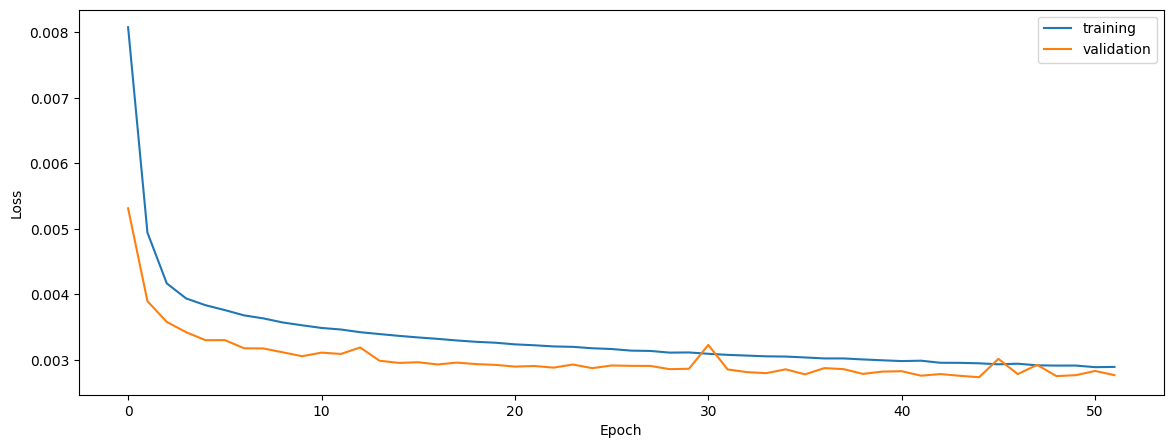

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.828764804906203
0.8266060882961004
0.8076047354564082


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8294162453800911
0.843284920587324
0.8189530603407379


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8284743561798334
0.8403148072932302
0.815920577569707


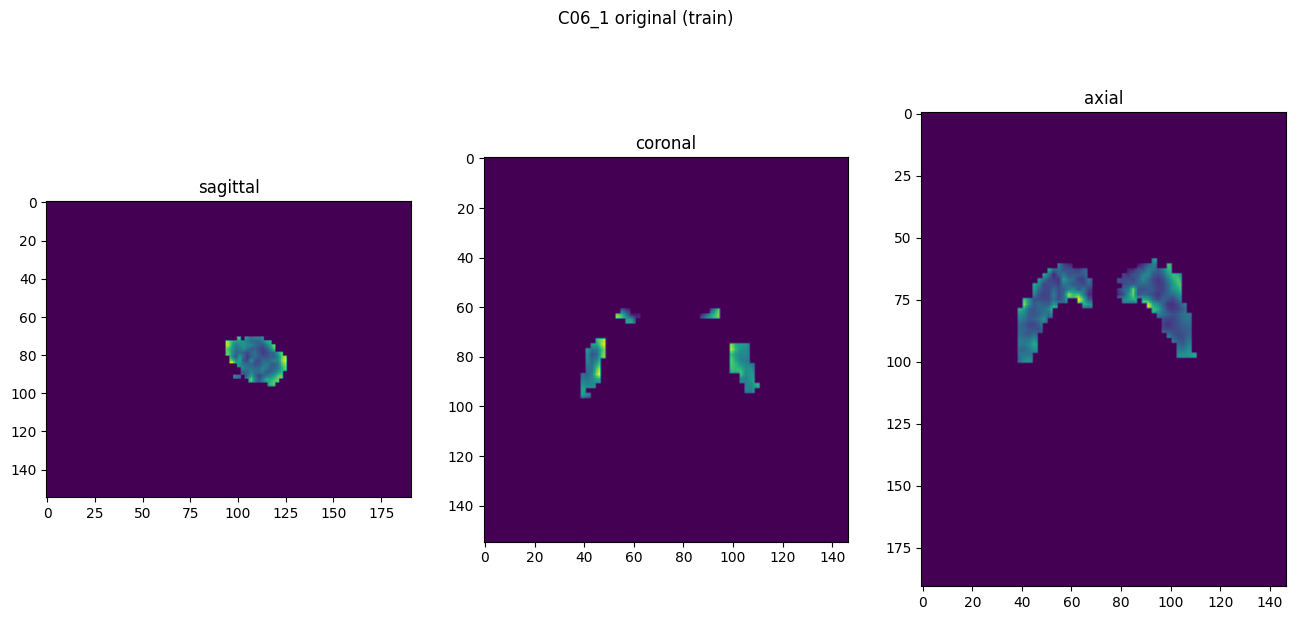

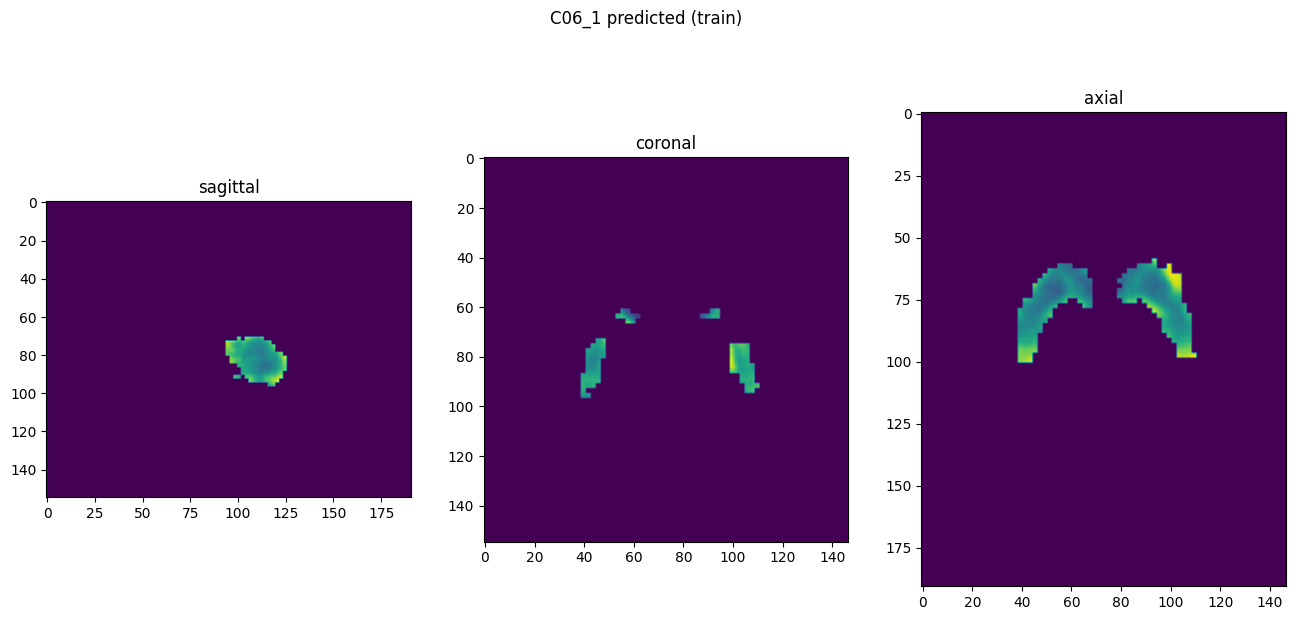

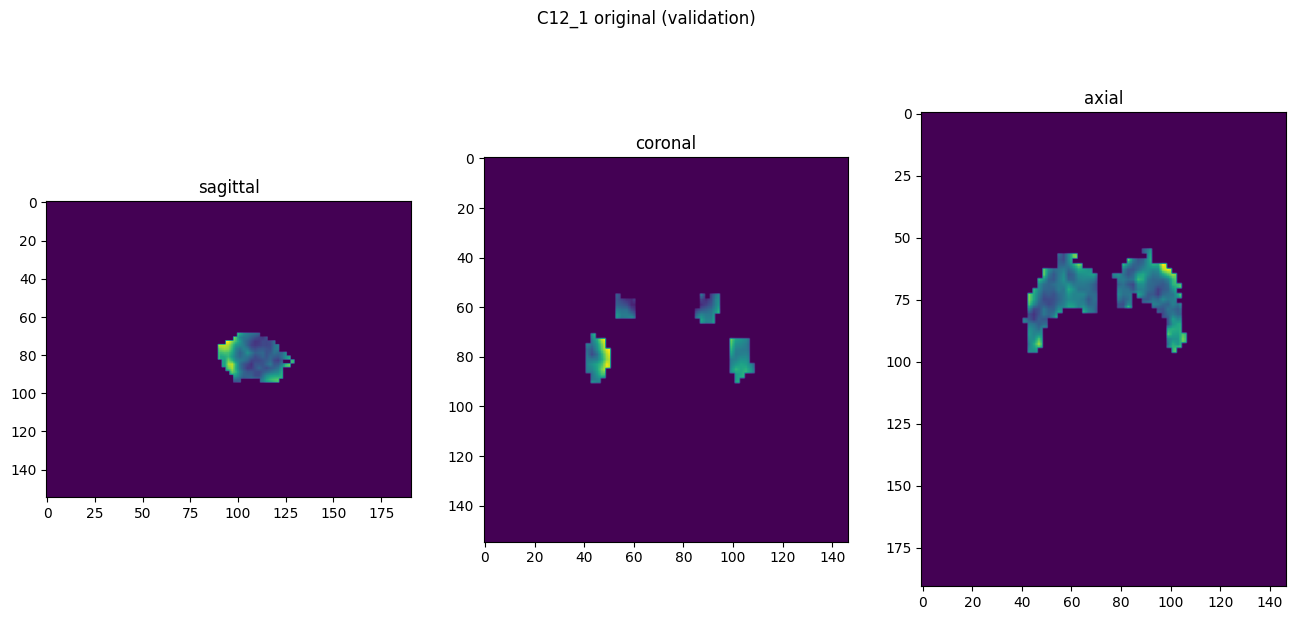

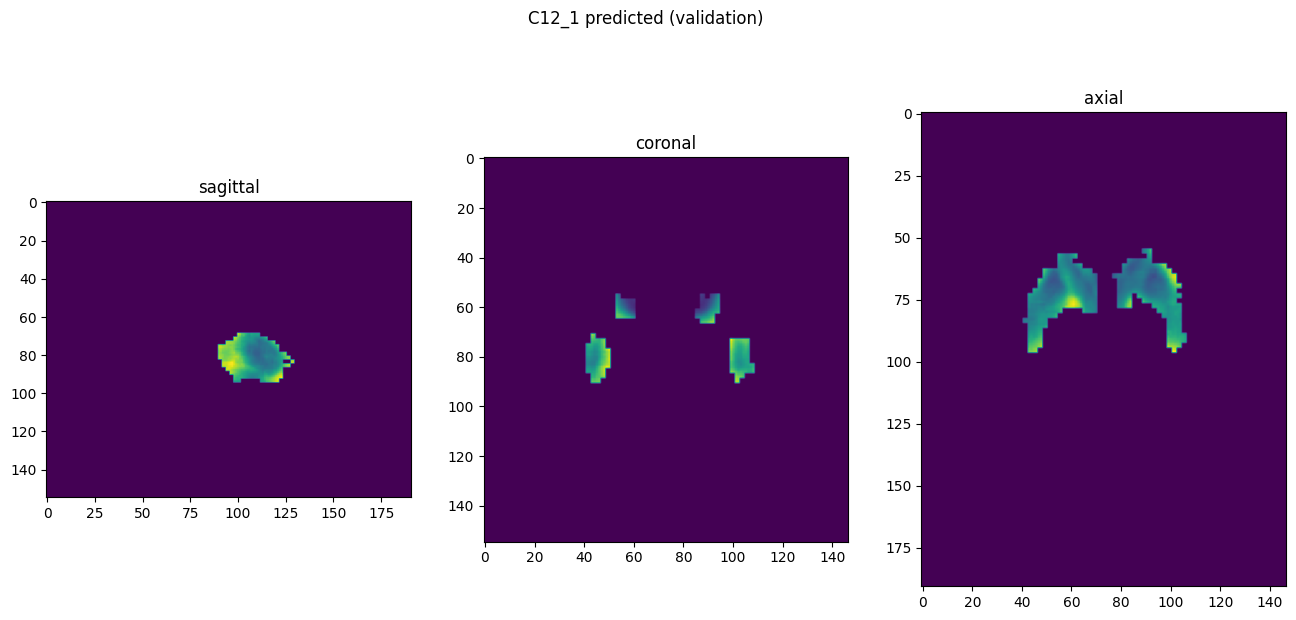

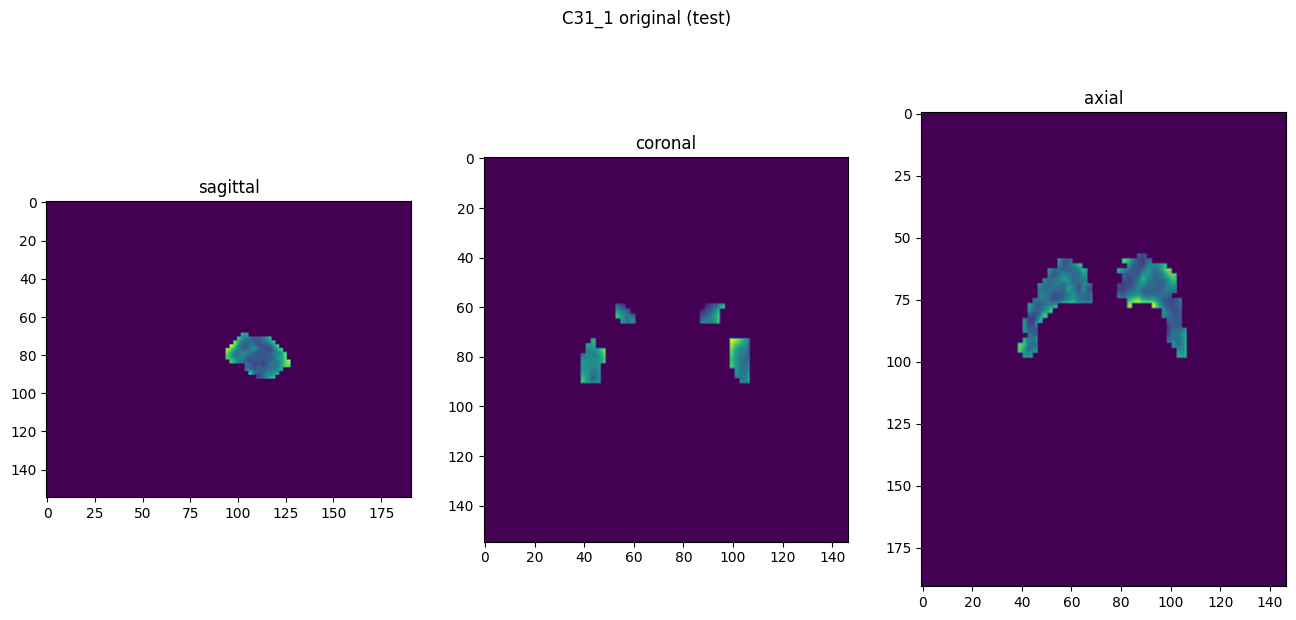

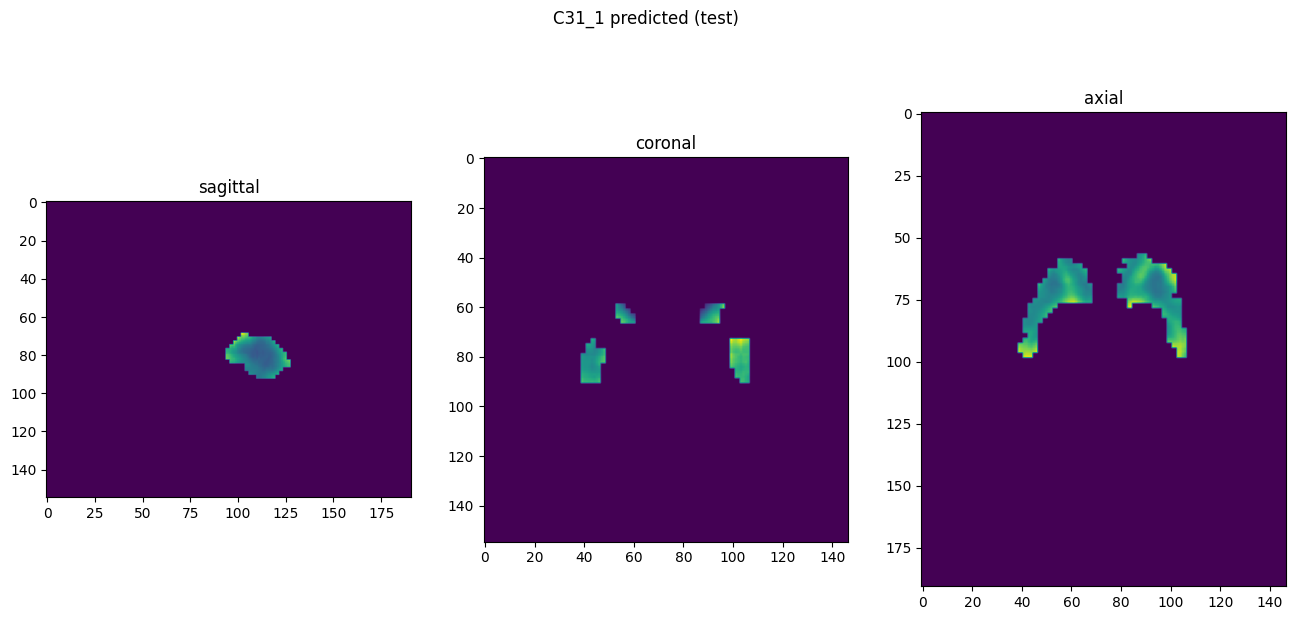

In [10]:
showResults(model, gen, threshold=None, background=False)